In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# ==============================================================================
# 1. FILE CONFIGURATION
# IMPORTANT: Replace the paths below with the actual location of your CSV files.
# ==============================================================================
file_paths = {
    "1e-5 (Conservative)": "wikipedia/experiments/run_20251211_175952/results/canary_details_full.csv",
    "5e-5 (Baseline)":     "wikipedia/experiments/run_20251203_134201/results/canary_details_full.csv",
    "1e-4 (Aggressive)":   "wikipedia/experiments/run_20251212_095946/results/canary_details_full.csv"
}

# Check if files exist before proceeding
for label, path in file_paths.items():
    if not os.path.exists(path):
        print(f"[WARNING] File not found: {path}")
    else:
        print(f"[OK] Found file for {label}")

[OK] Found file for 1e-5 (Conservative)
[OK] Found file for 5e-5 (Baseline)
[OK] Found file for 1e-4 (Aggressive)


In [6]:
# ==============================================================================
# 2. DATA LOADING & PROCESSING
# ==============================================================================
df_list = []

for label, path in file_paths.items():
    if os.path.exists(path):
        # Load the CSV
        tmp_df = pd.read_csv(path)
        
        # Add the Learning Rate column for plotting
        tmp_df['Learning Rate'] = label
        
        # Determine Entropy Type based on canary_id prefix ('he_' vs 'le_')
        # This logic assumes your IDs start with 'he_' for high entropy
        tmp_df['Entropy Type'] = tmp_df['canary_id'].apply(
            lambda x: 'High Entropy (Random)' if str(x).startswith('he_') else 'Low Entropy (Natural Lang.)'
        )
        
        df_list.append(tmp_df)

# Concatenate all dataframes into one
if df_list:
    full_df = pd.concat(df_list, ignore_index=True)
    print("Data loaded successfully.")
    print(f"Total rows: {len(full_df)}")
    
    # Calculate the mean per epoch, LR, and Entropy Type
    metrics_to_plot = ['mia_score', 'counterfactual_score', 'contextual_score']
    grouped_df = full_df.groupby(['epoch', 'Learning Rate', 'Entropy Type'])[metrics_to_plot].mean().reset_index()
    
    # Display the first few rows to verify
    display(grouped_df.head())
else:
    print("Error: No data loaded. Please check your file paths.")

Data loaded successfully.
Total rows: 3600


,epoch,Learning Rate,Entropy Type,mia_score,counterfactual_score,contextual_score
0,0,1e-4 (Aggressive),High Entropy (Random),0.329509,0.052319,0.048461
1,0,1e-4 (Aggressive),Low Entropy (Natural Lang.),0.163446,0.028484,0.021351
2,0,1e-5 (Conservative),High Entropy (Random),0.080834,0.013293,0.007851
3,0,1e-5 (Conservative),Low Entropy (Natural Lang.),-0.035704,-0.008044,-0.008044
4,0,5e-5 (Baseline),High Entropy (Random),0.342989,0.053958,0.045960


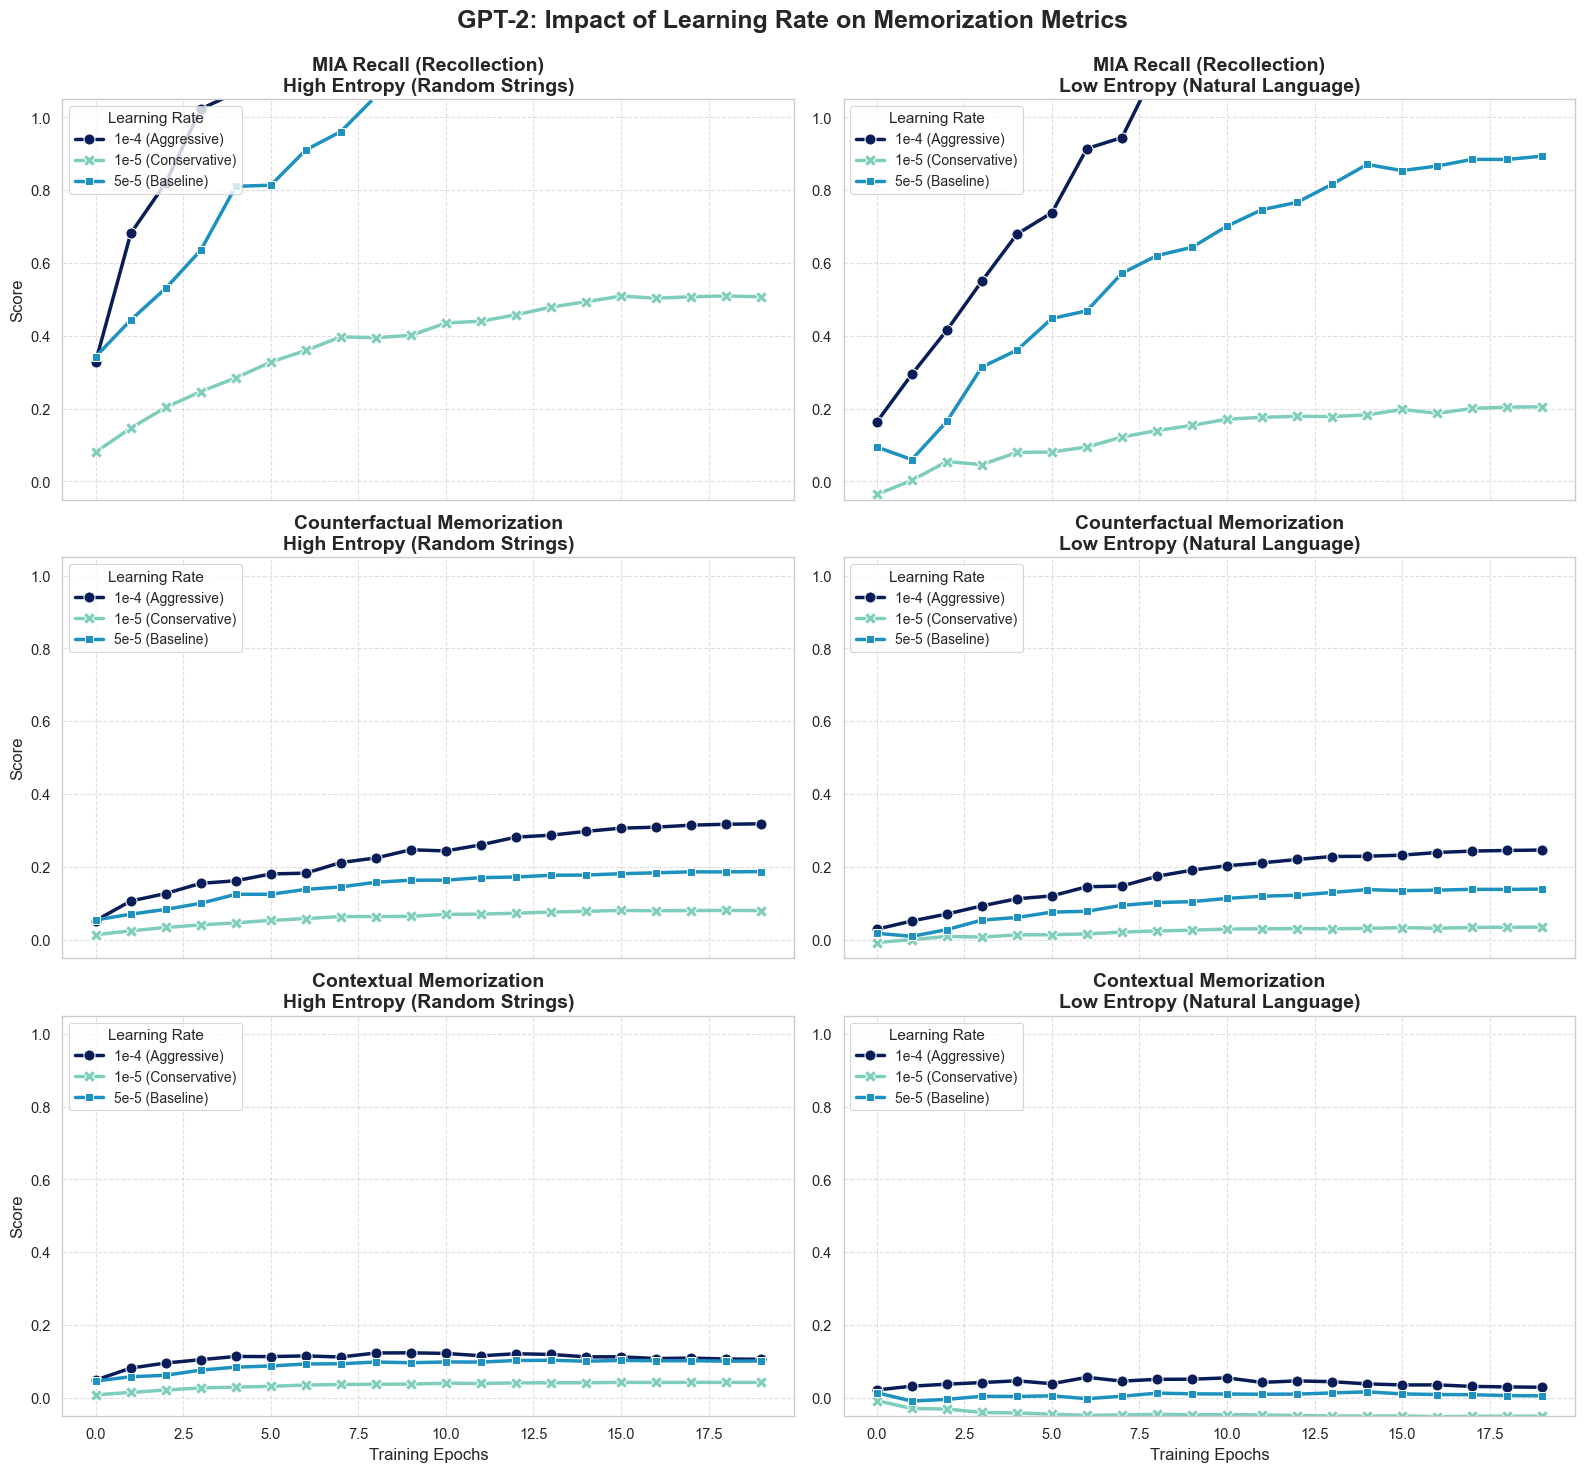

Figure saved as 'gpt2_lr_comparison.png'


In [7]:
# ==============================================================================
# 3. PLOTTING
# ==============================================================================

# Set visual style
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)

# Define a color palette representing intensity (Light Green -> Teal -> Dark Blue)
custom_palette = {
    "1e-5 (Conservative)": "#7fcdbb", 
    "5e-5 (Baseline)":     "#1d91c0", 
    "1e-4 (Aggressive)":   "#081d58"  
}

# Create a figure with 3 rows (Metrics) and 2 columns (Entropy Types)
fig, axes = plt.subplots(3, 2, figsize=(16, 15), sharex=True)

# Mapping metric names to readable titles
metric_titles = {
    'mia_score': 'MIA Recall (Recollection)',
    'counterfactual_score': 'Counterfactual Memorization',
    'contextual_score': 'Contextual Memorization'
}

# Iterate through metrics to generate subplots
metrics_list = ['mia_score', 'counterfactual_score', 'contextual_score']

for i, metric in enumerate(metrics_list):
    # --- Left Column: High Entropy ---
    sns.lineplot(
        data=grouped_df[grouped_df['Entropy Type'] == 'High Entropy (Random)'],
        x='epoch', y=metric, hue='Learning Rate', style='Learning Rate',
        markers=True, dashes=False, palette=custom_palette, ax=axes[i, 0],
        linewidth=2.5, markersize=8
    )
    axes[i, 0].set_title(f"{metric_titles[metric]}\nHigh Entropy (Random Strings)", fontsize=14, fontweight='bold')
    axes[i, 0].set_ylabel("Score", fontsize=12)
    axes[i, 0].grid(True, linestyle='--', alpha=0.6)
    
    # --- Right Column: Low Entropy ---
    sns.lineplot(
        data=grouped_df[grouped_df['Entropy Type'] == 'Low Entropy (Natural Lang.)'],
        x='epoch', y=metric, hue='Learning Rate', style='Learning Rate',
        markers=True, dashes=False, palette=custom_palette, ax=axes[i, 1],
        linewidth=2.5, markersize=8
    )
    axes[i, 1].set_title(f"{metric_titles[metric]}\nLow Entropy (Natural Language)", fontsize=14, fontweight='bold')
    axes[i, 1].set_ylabel("") # Hide Y label for cleaner look
    axes[i, 1].grid(True, linestyle='--', alpha=0.6)

# Final Layout Adjustments
for ax in axes.flat:
    ax.set_xlabel("Training Epochs", fontsize=12)
    # Set Y-axis limits slightly wider than 0-1 for better visibility
    ax.set_ylim(-0.05, 1.05) 
    # Improve Legend
    ax.legend(title="Learning Rate", loc='upper left', fontsize=10, title_fontsize=11)

plt.tight_layout()
plt.subplots_adjust(top=0.92) # Make space for the super title
plt.suptitle(f"GPT-2: Impact of Learning Rate on Memorization Metrics", fontsize=18, fontweight='bold')

# Show plot
plt.show()

# Save the figure
fig.savefig("gpt2_lr_comparison.png", dpi=300, bbox_inches='tight')
print("Figure saved as 'gpt2_lr_comparison.png'")